# 2 Transmons with resonator, Capacitance and qubit parameters computation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"
os.environ['OMPI_MCA_btl'] = 'tcp,self'
os.environ['OMPI_MCA_rmaps_base_oversubscribe'] = '1'

# Import useful packages
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from SQDMetal.Utilities.QUtilities import QUtilities
import matplotlib.pyplot as plt
from SQDMetal.Comps.Qubits import TransmonTaperedInsets
from SQDMetal.Comps.Test_capacitor import Smooth_CapacitorProngPin, Smooth_Capacitor_Semicircle
from SQDMetal.Comps.Resonators import ResonatorMeanderPinPin
from SQDMetal.Utilities.QubitDesigner import ResonatorHalfWave
from qiskit_metal.analyses import cpw_calculations
from SQDMetal.Utilities.Materials import Material
from SQDMetal.Utilities.CpwParams import CpwParams

### Qubit, resonator frequencies
qubit_freq = [4.5*1e9, 4.5*1e9]
res_freq_GHZ = qubit_freq[1] + 2.3 *1e9

## Design

In [2]:
## Resonator design parameters
resonator = ResonatorHalfWave(res_freq_GHZ)

m = Material("siliconcryo")

# CPW parameters
cpw_width = 10e-6
cpw = CpwParams(m.permittivity, 500e-6)
cpw_gap = cpw.get_gap_from_width(cpw_width)

l_fullwave, _, _ = cpw_calculations.guided_wavelength(
                freq=resonator.f0,
                line_width=cpw_width,
                line_gap=cpw_gap,
                substrate_thickness=cpw.dielectric_thickness,
                film_thickness=200e-9,
            )
l_halfwave = l_fullwave / 2

print(f"Resonator length (f = {res_freq_GHZ} GHz): {l_halfwave *1e3:.2f} mm")

Resonator length (f = 6800000000.0 GHz): 8.96 mm


In [ ]:
%matplotlib inline

# Set up chip design as planar
design = designs.DesignPlanar({}, overwrite_enabled=True)

# Set up chip dimensions 
design.chips.main.size.size_x = '5.0mm'
design.chips.main.size.size_y = '2.0mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0.0mm'
design.chips.main.size.center_y = '0mm'

# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = '10 um' #S
design.variables['cpw_gap'] = '6 um' #W 

#gui = MetalGUI(design)


########################################

TransmonTaperedInsets(design, 'Qubit1', options = Dict(pos_x = '-1.25mm', pos_y = '0.0mm', orientation = '0',
                                                       pocket_lower_tighten = '0.0um',pocket_height = '420um',chrgln_pin_x_offset="0um", chrgln_pin_y_offset="-10um"))


TransmonTaperedInsets(design, 'Qubit2', options = Dict(pos_x = '1.65mm', pos_y = '0.0mm', orientation = '0',
                                                       pocket_lower_tighten = '0.0um',pocket_height = '420um', chrgln_pin_x_offset="0um", chrgln_pin_y_offset="-10um"))


Smooth_Capacitor_Semicircle(design, 'Capacitor1',options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'Qubit1',pin='top_right_pin')), orientation=180,
                                                              rect_width = '160um',rect_length = '80um', semi_radius = '60um',
                                                              fillet_radius = '5um',fillet_resolution = 20))

Smooth_Capacitor_Semicircle(design, 'Capacitor2',options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'Qubit2',pin='top_left_pin')), orientation=0,
                                                              rect_width = '160um',rect_length = '80um', semi_radius = '60um',
                                                              fillet_radius = '5um',fillet_resolution = 20))

ResonatorMeanderPinPin(design, 'Resonator1', options = Dict(pin_inputs=Dict(start_pin=Dict(component='Capacitor1', pin='a'),
                                                            end_pin=Dict(component='Capacitor2', pin='a')),
                                            total_length = f"{l_halfwave*1e3}mm", start_left = False,
                                            trace_width = design.variables['cpw_width'], gap_width = design.variables['cpw_gap']))


#######################################

# Create GUI
#gui.rebuild()
design.rebuild()

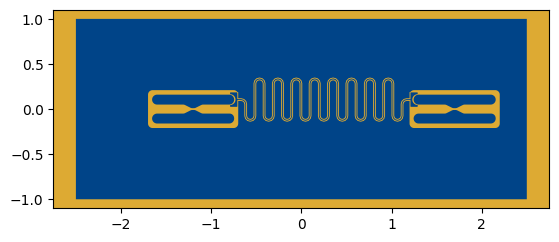

In [4]:
QUtilities.plot_all_components(design)
plt.show()

## Capacitance Simulation

In [5]:
from SQDMetal.PALACE.Capacitance_Simulation import PALACE_Capacitance_Simulation
import contextlib
import sys
from io import StringIO

#Eigenmode Simulation Options
user_defined_options = {
                "mesh_refinement": 0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                "solver_order": 2,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                "solns_to_save": 3,                                #number of solutions to save for E-field visualization - ordered by the entries in the computed capacitance matrix
                "solver_tol": 1.0e-8,                              #error residual tolerance for iterative solver
                "solver_maxits": 200,                              #number of solver iterations
                "fillet_resolution":16,                            #number of vertices per quarter turn on a filleted path
                "palace_dir":"~/repo/spack/opt/spack/linux-skylake/palace-0.15.0-p26f6lzvfjt4qemxgkdpjhhyogo7axk4/bin/palace",#"PATH/TO/PALACE/BINARY",
                "num_cpus": 16,                                  #number of threads to use in PALACE simulation
                #e.g.: "palace_dir":"/home/prasanna/spack/opt/spack/linux-ubuntu24.04-zen2/gcc-13.2.0/palace-0.12.0-q65qvkwsa5zglixv3rmm424wqsu3mcpv/bin/palace"
                }

#Create the Palace capacitance simulation
cap_sim = PALACE_Capacitance_Simulation(name = '2_transmons_wRes_comp',                                      #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "",                                  #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                             #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                           #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        create_files = True)                                        #create mesh, config and HPC batch files

#Add metallic elements from layer 1 in design file
cap_sim.add_metallic(1)

#Add ground plane to simulations
cap_sim.add_ground_plane()

#Fine mesh the transmon cross qubit region
cap_sim.fine_mesh_components(['Qubit1', 'Qubit2'], min_size=12e-6, max_size=100e-6, taper_dist_min=10e-6, metals_only=False)

#Fine mesh resonator, launch pads and transmission line
cap_sim.fine_mesh_components(['Resonator1','Capacitor1','Capacitor2'], min_size=12e-6, max_size=120e-6, taper_dist_min=10e-6)

#This will prepare the mesh file and the config file
cap_sim.prepare_simulation()

capMat = cap_sim.run()

Error   : Gmsh has not been initialized
Error   : Gmsh has not been initialized


>> /usr/bin/mpirun -n 16 /home/leont/repo/spack/opt/spack/linux-skylake/palace-0.15.0-p26f6lzvfjt4qemxgkdpjhhyogo7axk4/bin/palace-x86_64.bin 2_transmons_wRes_comp.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/


--> Warning!
Output folder is not empty; program will overwrite content! (outputFiles)
Git changeset ID: b676277
Running with 16 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 1128 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 16 subdomains

Characteristic length and time scales:
 Lc = 6.000e-03 m, tc = 2.001e-02 ns

Mesh curvature order: 1
Mesh bounding box:
 (Xmin, Ymin, Zmin) = (-3.000e-03, -1.200e-03, -2.800e-04) m
 (Xmax, Ymax, Zmax) = (+3.000e-03, +1.200e-03, +2.800e-04) m

Parallel Mesh Stats:

          

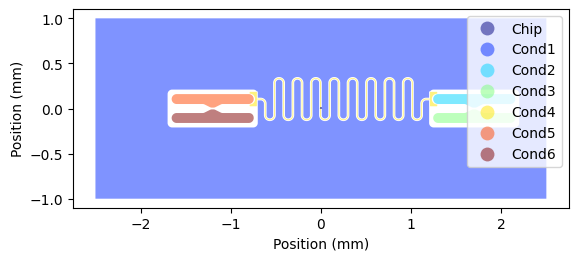

In [6]:
#Display the indices of the conductors to match with capacitance matrix - it will be automatically generated with the output anyway
cap_sim.display_conductor_indices()
plt.show()

In [7]:
# Gives qubit parameters
results = cap_sim.calc_params_2_floating_transmons(print_all_capacitances=True,  
                                            qubit_freq=(qubit_freq),
                                            res = resonator
                                            )

### 

Capacitance Results
--------------------
C1-Ground        =     73.452 fF
C2-Ground        =     79.691 fF
C3-Ground        =     73.500 fF
C4-Ground        =     79.727 fF
CQ1              =     78.826 fF
CQ2              =     78.839 fF
Cg1              =      7.124 fF
Cg2              =      7.163 fF
C_r              =   1445.730 fF
C1_prime         =     85.915 fF
C2_prime         =     85.967 fF
C_r_prime        =   1458.830 fF
Cg1_prime        =   8800.541 fF
Cg2_prime        =   8757.446 fF

Readout Resonator
-------------------
f_res            =      6.800 GHz
L_res            =    745.009 pH
C_res            =    735.294 fF
Circuit Parameters
-------------------
f_qubit1         =      4.500 GHz
f_qubit2         =      4.500 GHz
E_C1             =    225.457 MHz
E_C2             =    225.321 MHz
E_Cc             =      0.183 MHz
g1               =     82.732 MHz
g2               =     83.176 MHz

Target Junction Parameters
 (for f_qubit1 = 4.5 GHz)
--------------------------


In [8]:
print('Res_ground: ',capMat[0,3]*1e15, 'fF')
print('Pad1 to pad2: ',capMat[1,2]*1e15, 'fF')
print('Res to pad1: ',capMat[1,3]*1e15, 'fF')
print('Res to pad2: ',capMat[2,3]*1e15, 'fF')

Res_ground:  -1445.730348239 fF
Pad1 to pad2:  -35.65852572964 fF
Res to pad1:  -17.64799832657 fF
Res to pad2:  -2.3543623043 fF


In [9]:
resonator.get_res_inductance()

7.450087032524837e-10